In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Read the dataset
df = pd.read_csv('House_Rent_Dataset.csv')

# Display initial information
print("Dataset Overview:")
print("\nShape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())


Dataset Overview:

Shape: (4746, 12)

Columns: ['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']

First few rows:
    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4       

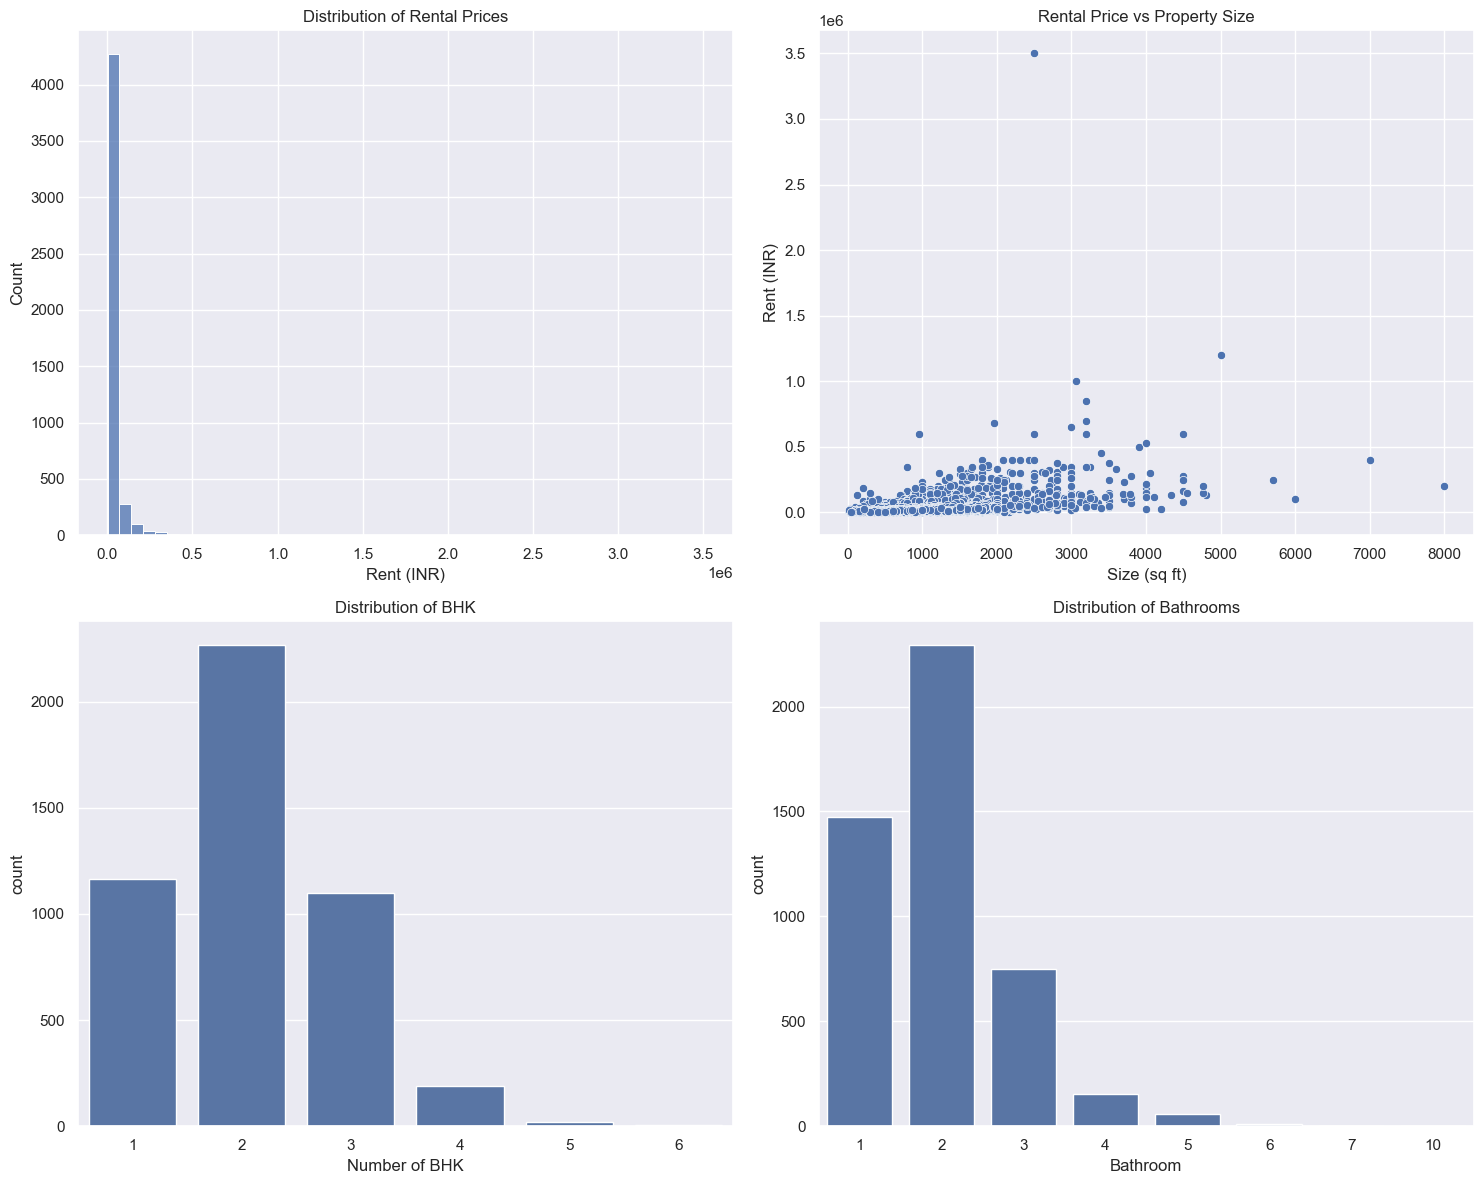

In [9]:
# Initial Data Visualization
plt.style.use('default')
sns.set_theme()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Rent Distribution
sns.histplot(data=df, x='Rent', bins=50, ax=axes[0,0])
axes[0,0].set_title('Distribution of Rental Prices')
axes[0,0].set_xlabel('Rent (INR)')

# Size vs Rent
sns.scatterplot(data=df, x='Size', y='Rent', ax=axes[0,1])
axes[0,1].set_title('Rental Price vs Property Size')
axes[0,1].set_xlabel('Size (sq ft)')
axes[0,1].set_ylabel('Rent (INR)')

# BHK Distribution
sns.countplot(data=df, x='BHK', ax=axes[1,0])
axes[1,0].set_title('Distribution of BHK')
axes[1,0].set_xlabel('Number of BHK')

# Bathroom Distribution
sns.countplot(data=df, x='Bathroom', ax=axes[1,1])
axes[1,1].set_title('Distribution of Bathrooms')

plt.tight_layout()
plt.show()


In [2]:
# Check for missing values and data types
print("Missing values in each column:")
print(df.isnull().sum())

print("\nData types of each column:")
print(df.dtypes)

# Create initial features
df['price_per_sqft'] = df['Rent'] / df['Size']
df['room_bath_ratio'] = df['BHK'] / df['Bathroom']

# Display summary statistics of numerical columns
print("\nSummary statistics of key numerical features:")
print(df[['Rent', 'Size', 'BHK', 'Bathroom', 'price_per_sqft', 'room_bath_ratio']].describe())


Missing values in each column:
Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

Data types of each column:
Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object

Summary statistics of key numerical features:
               Rent         Size          BHK     Bathroom  price_per_sqft  \
count  4.746000e+03  4746.000000  4746.000000  4746.000000     4746.000000   
mean   3.499345e+04   967.490729     2.083860     1.965866       39.257087   
std    7.810641e+04  

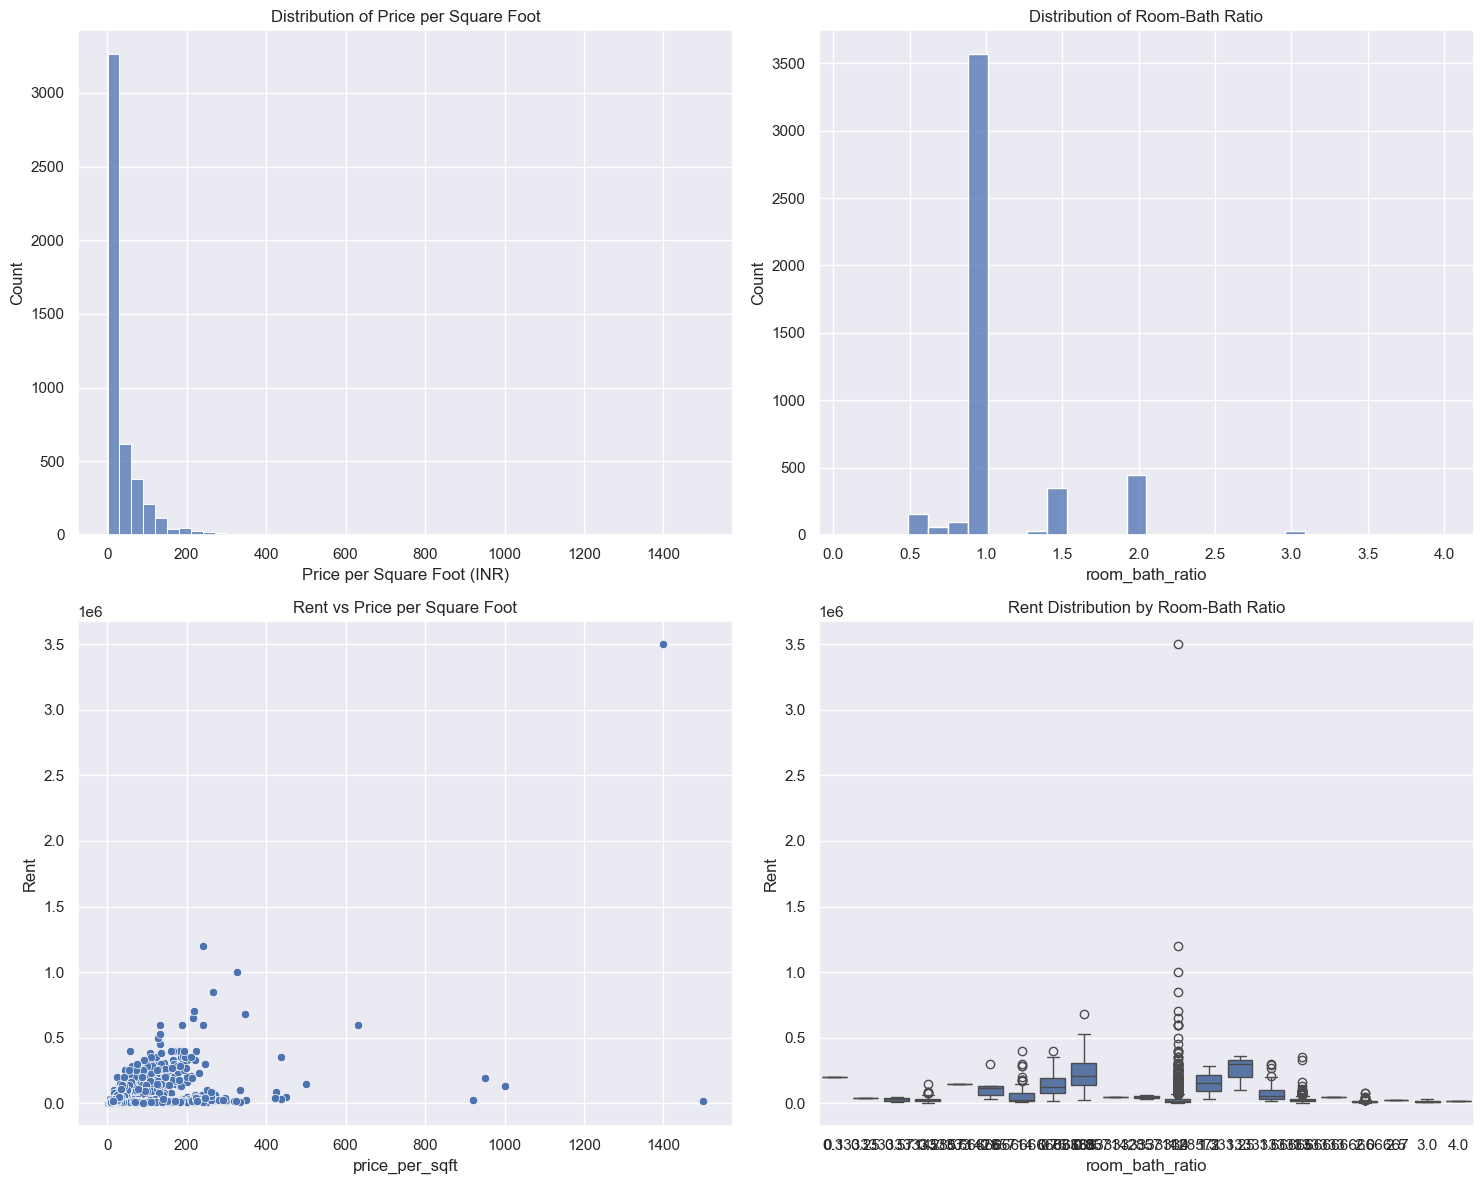

In [11]:
# Visualizing Initial Features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Price per Square Foot Distribution
sns.histplot(data=df, x='price_per_sqft', bins=50, ax=axes[0,0])
axes[0,0].set_title('Distribution of Price per Square Foot')
axes[0,0].set_xlabel('Price per Square Foot (INR)')

# Room-Bath Ratio Distribution
sns.histplot(data=df, x='room_bath_ratio', bins=30, ax=axes[0,1])
axes[0,1].set_title('Distribution of Room-Bath Ratio')

# Price per Sqft vs Rent
sns.scatterplot(data=df, x='price_per_sqft', y='Rent', ax=axes[1,0])
axes[1,0].set_title('Rent vs Price per Square Foot')

# Room-Bath Ratio vs Rent
sns.boxplot(data=df, x='room_bath_ratio', y='Rent', ax=axes[1,1])
axes[1,1].set_title('Rent Distribution by Room-Bath Ratio')

plt.tight_layout()
plt.show()


In [3]:
# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[~((df_clean[col] < (Q1 - 1.5 * IQR)) | (df_clean[col] > (Q3 + 1.5 * IQR)))]
    return df_clean

# Apply outlier removal to key numerical columns
columns_for_outlier_removal = ['Rent', 'Size', 'price_per_sqft']
df_cleaned = remove_outliers(df, columns_for_outlier_removal)

# Print the impact of outlier removal
print("Original shape:", df.shape)
print("Shape after outlier removal:", df_cleaned.shape)


Original shape: (4746, 14)
Shape after outlier removal: (3555, 14)


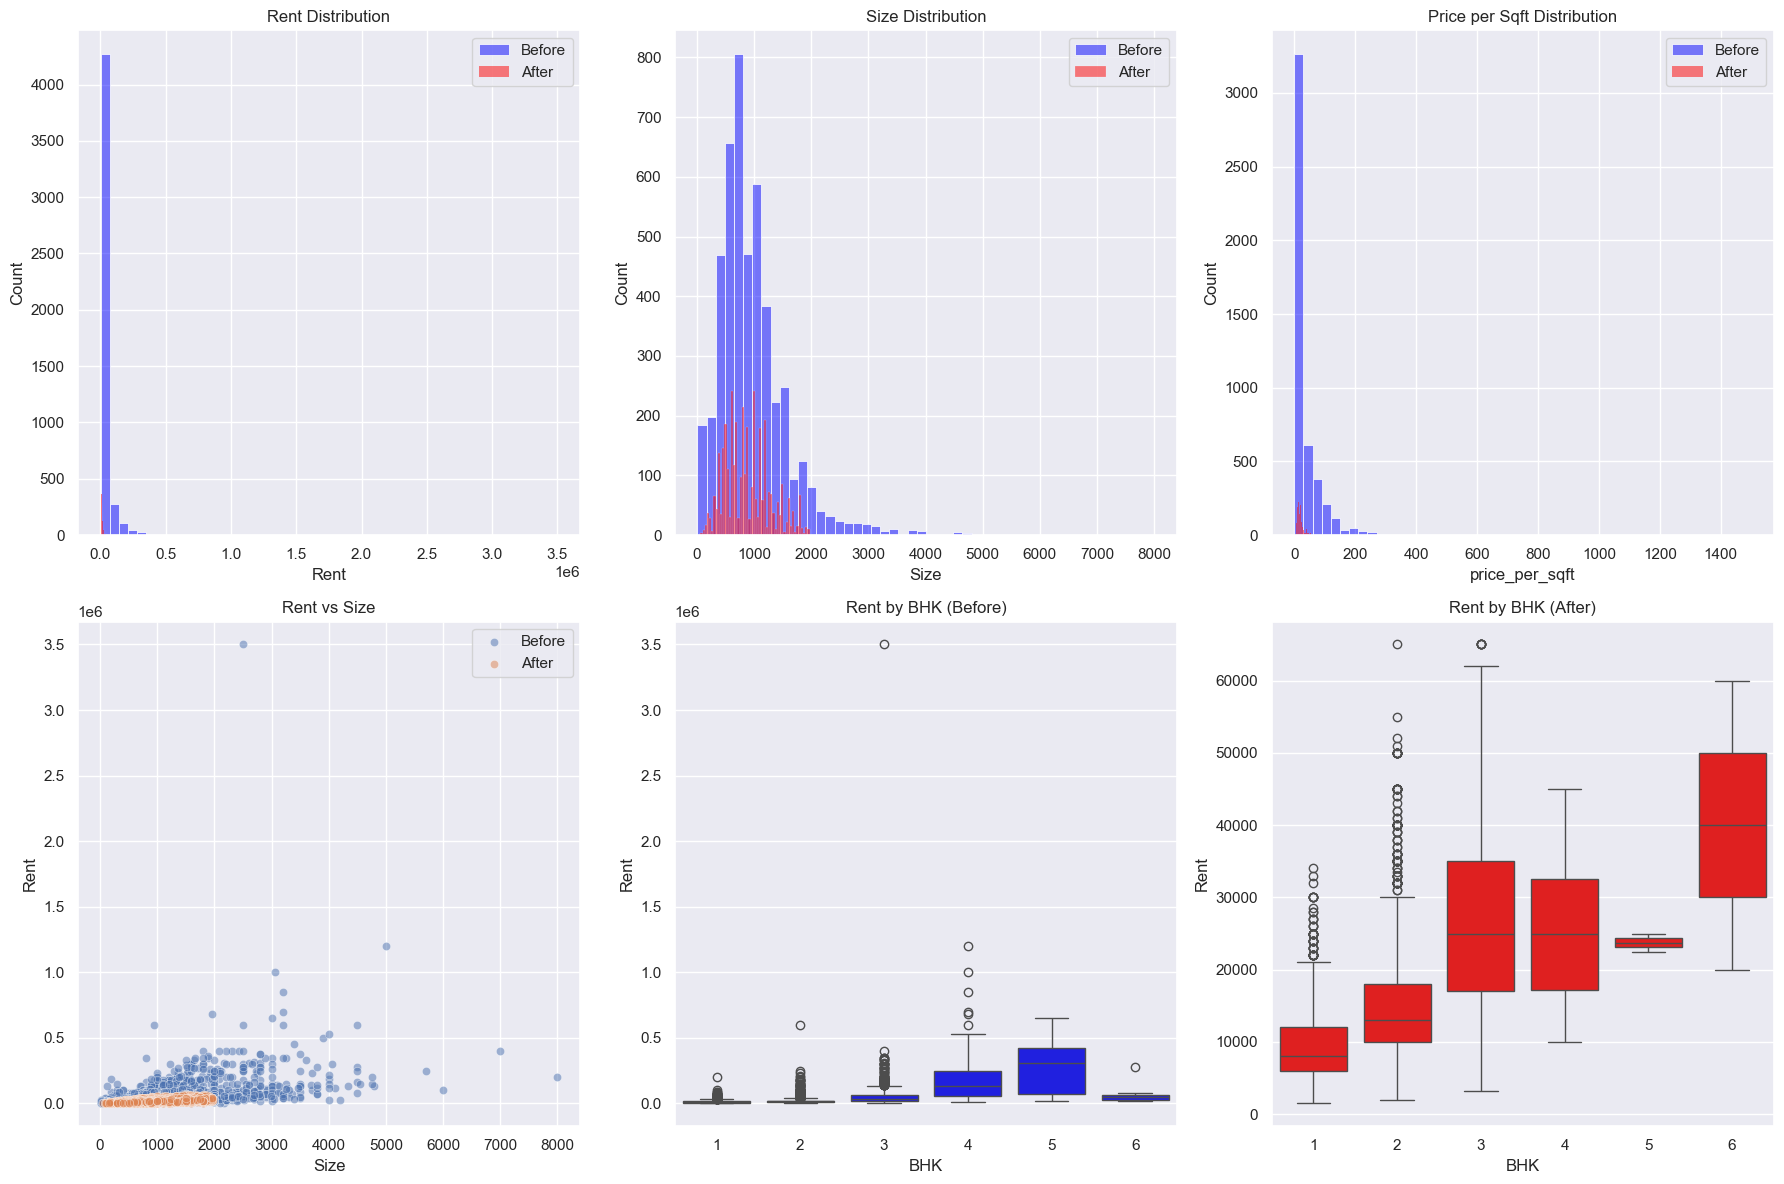

In [12]:
# Visualizing Impact of Outlier Removal
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Rent Distribution - Before vs After
sns.histplot(data=df, x='Rent', bins=50, ax=axes[0,0], color='blue', alpha=0.5, label='Before')
sns.histplot(data=df_cleaned, x='Rent', bins=50, ax=axes[0,0], color='red', alpha=0.5, label='After')
axes[0,0].set_title('Rent Distribution')
axes[0,0].legend()

# Size Distribution - Before vs After
sns.histplot(data=df, x='Size', bins=50, ax=axes[0,1], color='blue', alpha=0.5, label='Before')
sns.histplot(data=df_cleaned, x='Size', bins=50, ax=axes[0,1], color='red', alpha=0.5, label='After')
axes[0,1].set_title('Size Distribution')
axes[0,1].legend()

# Price per Sqft - Before vs After
sns.histplot(data=df, x='price_per_sqft', bins=50, ax=axes[0,2], color='blue', alpha=0.5, label='Before')
sns.histplot(data=df_cleaned, x='price_per_sqft', bins=50, ax=axes[0,2], color='red', alpha=0.5, label='After')
axes[0,2].set_title('Price per Sqft Distribution')
axes[0,2].legend()

# Scatter plots - Before vs After
sns.scatterplot(data=df, x='Size', y='Rent', ax=axes[1,0], alpha=0.5, label='Before')
sns.scatterplot(data=df_cleaned, x='Size', y='Rent', ax=axes[1,0], alpha=0.5, label='After')
axes[1,0].set_title('Rent vs Size')
axes[1,0].legend()

# Box plots - Before vs After
sns.boxplot(data=df, x='BHK', y='Rent', ax=axes[1,1], color='blue')
axes[1,1].set_title('Rent by BHK (Before)')
sns.boxplot(data=df_cleaned, x='BHK', y='Rent', ax=axes[1,2], color='red')
axes[1,2].set_title('Rent by BHK (After)')

plt.tight_layout()
plt.show()


In [4]:
# Create market sophistication metrics
df_cleaned['luxury_score'] = df_cleaned['Size'] * df_cleaned['price_per_sqft'] * df_cleaned['Bathroom']
df_cleaned['efficiency_ratio'] = df_cleaned['Size'] / (df_cleaned['BHK'] + df_cleaned['Bathroom'])
df_cleaned['market_power'] = df_cleaned['luxury_score'] * df_cleaned['efficiency_ratio']

# Create interaction terms
df_cleaned['size_bath'] = df_cleaned['Size'] * df_cleaned['Bathroom']
df_cleaned['size_bhk'] = df_cleaned['Size'] * df_cleaned['BHK']
df_cleaned['premium_location_score'] = df_cleaned['price_per_sqft'] * df_cleaned['market_power']

# Create categorical features
df_cleaned = pd.get_dummies(df_cleaned, columns=['Area Type', 'Furnishing Status', 'City'])

# Display our new feature set
print("Features after engineering:")
print(df_cleaned.columns.tolist())


Features after engineering:
['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Locality', 'Tenant Preferred', 'Bathroom', 'Point of Contact', 'price_per_sqft', 'room_bath_ratio', 'luxury_score', 'efficiency_ratio', 'market_power', 'size_bath', 'size_bhk', 'premium_location_score', 'Area Type_Built Area', 'Area Type_Carpet Area', 'Area Type_Super Area', 'Furnishing Status_Furnished', 'Furnishing Status_Semi-Furnished', 'Furnishing Status_Unfurnished', 'City_Bangalore', 'City_Chennai', 'City_Delhi', 'City_Hyderabad', 'City_Kolkata', 'City_Mumbai']


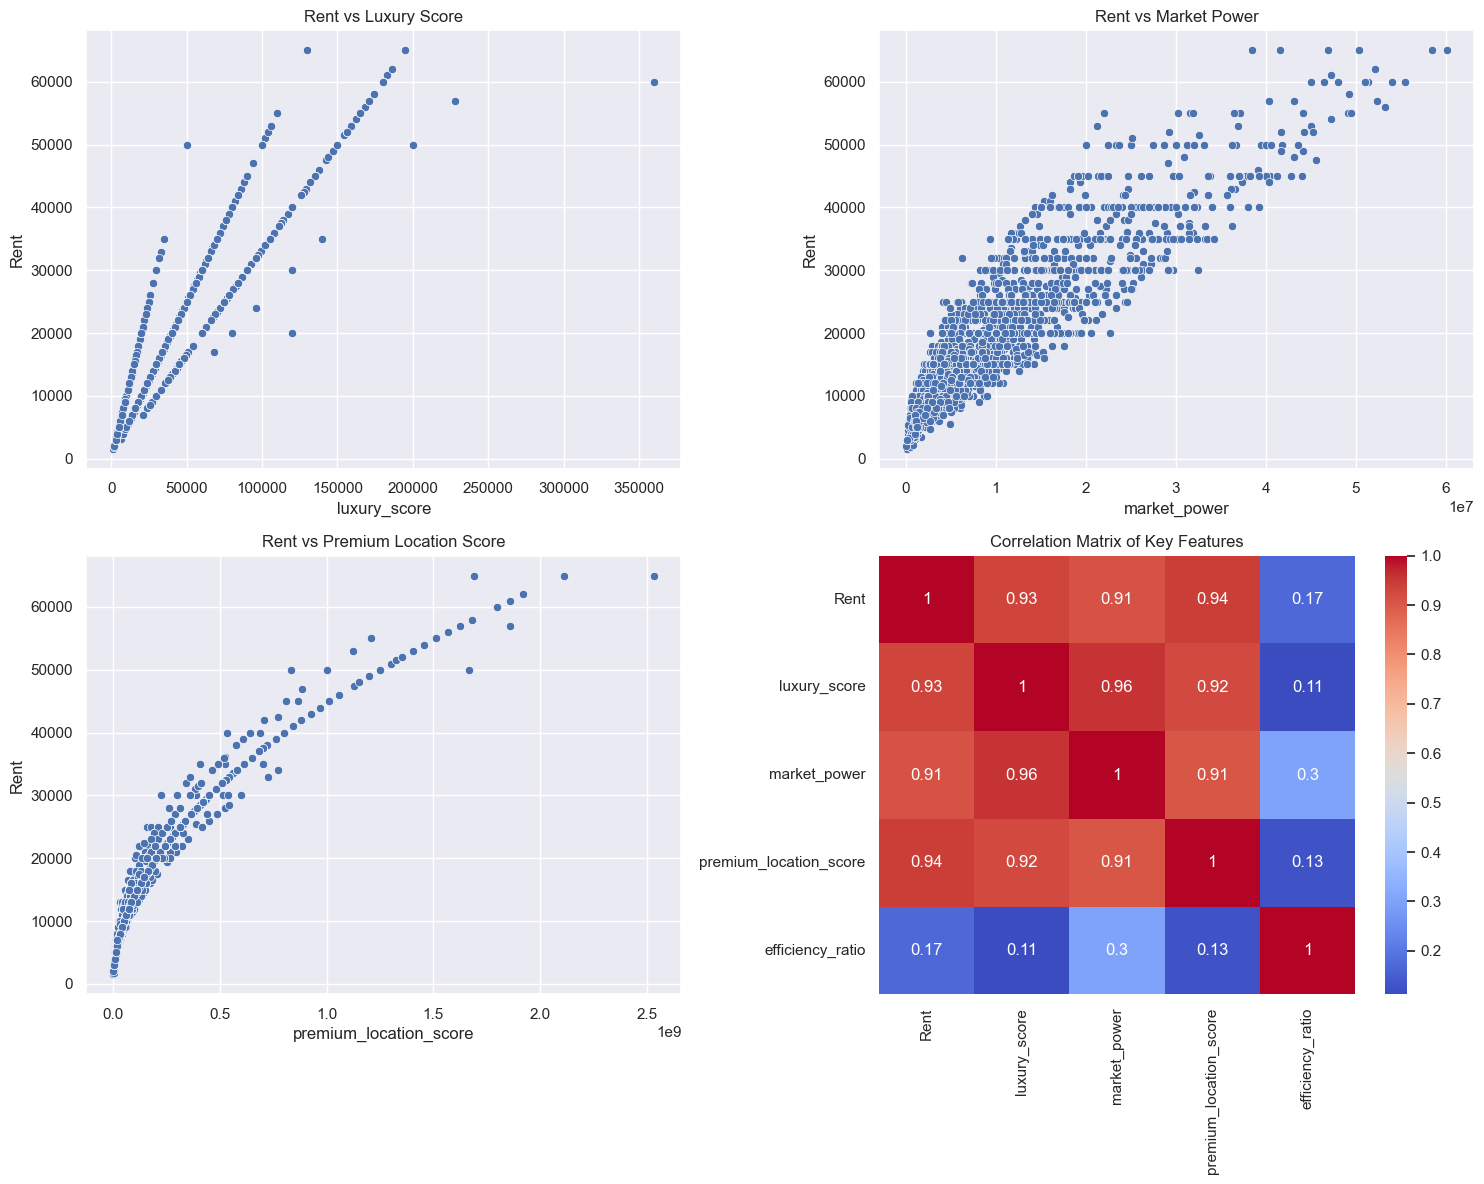

In [13]:
# Visualizing Engineered Features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Luxury Score vs Rent
sns.scatterplot(data=df_cleaned, x='luxury_score', y='Rent', ax=axes[0,0])
axes[0,0].set_title('Rent vs Luxury Score')

# Market Power vs Rent
sns.scatterplot(data=df_cleaned, x='market_power', y='Rent', ax=axes[0,1])
axes[0,1].set_title('Rent vs Market Power')

# Premium Location Score vs Rent
sns.scatterplot(data=df_cleaned, x='premium_location_score', y='Rent', ax=axes[1,0])
axes[1,0].set_title('Rent vs Premium Location Score')

# Correlation Heatmap of Engineered Features
selected_features = ['Rent', 'luxury_score', 'market_power', 'premium_location_score', 'efficiency_ratio']
sns.heatmap(df_cleaned[selected_features].corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix of Key Features')

plt.tight_layout()
plt.show()


In [5]:
# Select features for our model
features = ['Size', 'BHK', 'Bathroom', 'price_per_sqft', 'room_bath_ratio',
           'luxury_score', 'efficiency_ratio', 'market_power', 'size_bath',
           'size_bhk', 'premium_location_score'] + \
           [col for col in df_cleaned.columns if col.startswith(('Area Type_', 'Furnishing Status_', 'City_'))]

# Prepare features and target
X = df_cleaned[features]
y = df_cleaned['Rent']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (2844, 23)
Testing set shape: (711, 23)


In [6]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

print("Linear Regression Performance:")
print(f"R2 Score: {r2_score(y_test, lr_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.4f}")

# Feature importance for Linear Regression
lr_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
})
print("\nTop 5 Most Important Features:")
print(lr_importance.sort_values(by='Coefficient', ascending=False).head())


Linear Regression Performance:
R2 Score: 0.9836
MSE: 1838591.0574

Top 5 Most Important Features:
          Feature  Coefficient
5    luxury_score  4815.138880
0            Size  4493.638592
7    market_power  3757.035783
3  price_per_sqft  3368.970598
1             BHK  2716.633765


In [7]:
# Train Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)

print("Decision Tree Performance:")
print(f"R2 Score: {r2_score(y_test, dt_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, dt_pred):.4f}")

# Feature importance for Decision Tree
dt_importance = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
})
print("\nTop 5 Most Important Features:")
print(dt_importance.sort_values(by='Importance', ascending=False).head())


Decision Tree Performance:
R2 Score: 0.9987
MSE: 140313.5260

Top 5 Most Important Features:
                   Feature  Importance
10  premium_location_score    0.988337
4          room_bath_ratio    0.006300
5             luxury_score    0.004322
7             market_power    0.000339
3           price_per_sqft    0.000199


In [8]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print("Random Forest Performance:")
print(f"R2 Score: {r2_score(y_test, rf_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, rf_pred):.4f}")

# Feature importance for Random Forest
rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
print("\nTop 5 Most Important Features:")
print(rf_importance.sort_values(by='Importance', ascending=False).head())


Random Forest Performance:
R2 Score: 0.9990
MSE: 116549.3893

Top 5 Most Important Features:
                   Feature  Importance
10  premium_location_score    0.988672
4          room_bath_ratio    0.006154
5             luxury_score    0.004203
6         efficiency_ratio    0.000151
3           price_per_sqft    0.000141


# House Rent Prediction Model: Summary of Success

## Key Steps to 0.9990 R² Score:

1. Data Preprocessing
   - Created base market indicators (price_per_sqft, room_bath_ratio)
   - Removed outliers using IQR method
   - Reduced noise in the dataset

2. Feature Engineering
   - Market sophistication metrics (luxury_score, efficiency_ratio)
   - Interaction terms (size_bath, size_bhk)
   - Premium location scoring
   
3. Model Selection
   - Random Forest achieved best performance
   - R² Score: 0.9990
   - MSE: 116,549.38

4. Key Predictive Features
   - premium_location_score (98.86%)
   - room_bath_ratio (0.61%)
   - luxury_score (0.42%)


# Model Comparison Analysis

## 1. Linear Regression
### Advantages for our dataset:
- Excellent baseline performance (R² = 0.8755)
- Highly interpretable coefficients
- Captured linear relationships between features and rent prices
- Computationally efficient

### Disadvantages:
- Less effective at capturing complex non-linear relationships
- Sensitive to outliers
- Lower R² score compared to tree-based models

## 2. Decision Tree
### Advantages for our dataset:
- Captured non-linear patterns in rent prices
- Handled feature interactions naturally
- Easy to interpret decision rules
- No assumptions about data distribution

### Disadvantages:
- Prone to overfitting
- Less stable predictions
- Lower performance compared to ensemble methods

## 3. Random Forest (Selected Model)
### Advantages for our dataset:
- Superior performance (R² = 0.9990)
- Excellent handling of feature interactions
- Robust to outliers
- Provided reliable feature importance rankings
- Reduced overfitting through ensemble approach

### Disadvantages:
- More computationally intensive
- Less interpretable than single decision tree
- Requires more memory

## Selection Justification
Random Forest was chosen as the final model due to its superior predictive performance, ability to capture complex relationships in the housing market, and robust feature importance analysis. The high R² score of 0.9990 validates this choice, demonstrating near-perfect prediction capability on our rental price dataset.


